In [1]:
from location_finding import LocationFinding, StaticDesign, NestedMonteCarlo, plot_posterior_comparison
from location_finding import run_myopic_design, run_myopic_ba_design
import torch
from tqdm import trange, tqdm
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import numpy as np

import sys

sys.path.append("../BayesFlow")


import bayesflow as bf

/Users/zizi/miniconda3/envs/bf-torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Location finding experiments

Set up the model. We are using the same hyperparameters as in the DAD paper [1].

In [2]:
torch.manual_seed(20241015)
testing = False
train_batch_shape = (128,)
test_batch_shape = (4,)
eval_batch_shape = (2, 1) if testing else (32, 8)  # to eval the EIGs

K = 2
num_designs = 30
p = 2
num_params = K * p
num_grad_steps = 100 if testing else 5000
initial_designs = torch.randn(num_designs, p)

_model = LocationFinding(
    K=K,
    p=p,
    T=num_designs,
    design_func=StaticDesign(designs=torch.randn(num_designs, p), learn_designs=True),
)

test_thetas = _model.prior().sample(test_batch_shape)  # [test_batch_shape, K, p]
eval_thetas = _model.prior().sample(eval_batch_shape) # [eval_batch_shape, K, p]

nmc_eval = NestedMonteCarlo(prior=_model.prior(), outcome_likelihood=_model.outcome_likelihood, num_inner_samples=100000)
eig_estimates_before_train = nmc_eval.estimate(params=eval_thetas, **_model.run_policy(eval_thetas))
print(f"Before training: EIG lower bound: {eig_estimates_before_train['lb']}; EIG upper bound: {eig_estimates_before_train['ub']}")

100%|██████████| 32/32 [00:23<00:00,  1.38it/s]

Before training: EIG lower bound: (8.236522674560547, 0.13150005342546023); EIG upper bound: (8.447126388549805, 0.16451478621881693)


For evaluation, we'll use 256 rollouts, same as in the DAD paper. 
On my laptop (Apple M3 Max, 16 cpu cores), it takes about 3.5 minutes to run a single rollout of 30 designs. 
Average time per rollout in parallel (via `joblib`) is about 1.5min, for a total runtime of about 6 hours.


## Myopic adaptive design vs Static design

Table 1 in the paper shows that the myopic adaptive design strategy using variational posteriors performs on par with the static design strategy. This is a rather unusual result since we would expect that an adaptive strategy, albeit myopic, would perform better than a static one. The reason for this underperformance was the fact that we used a simple Gaussian variational family, which is very far from the true posteriors in this model. The true posteriors (using ramdomly initialised designs) look like this:

In [3]:
illustrative_data = _model.run_policy(test_thetas)

In [4]:
hmc_samples = []
for t in tqdm(range(num_designs), desc="Running HMC"):
    hmc_samples.append(
        _model.run_hmc_posterior(
            designs=illustrative_data["designs"][..., :(t+1)], 
            outcomes=illustrative_data["outcomes"][..., :(t+1)], 
            num_chains=4, 
            num_samples=1000, 
        ) # [B, samples, K, p]
    )

Running HMC: 100%|██████████| 30/30 [02:39<00:00,  5.30s/it]


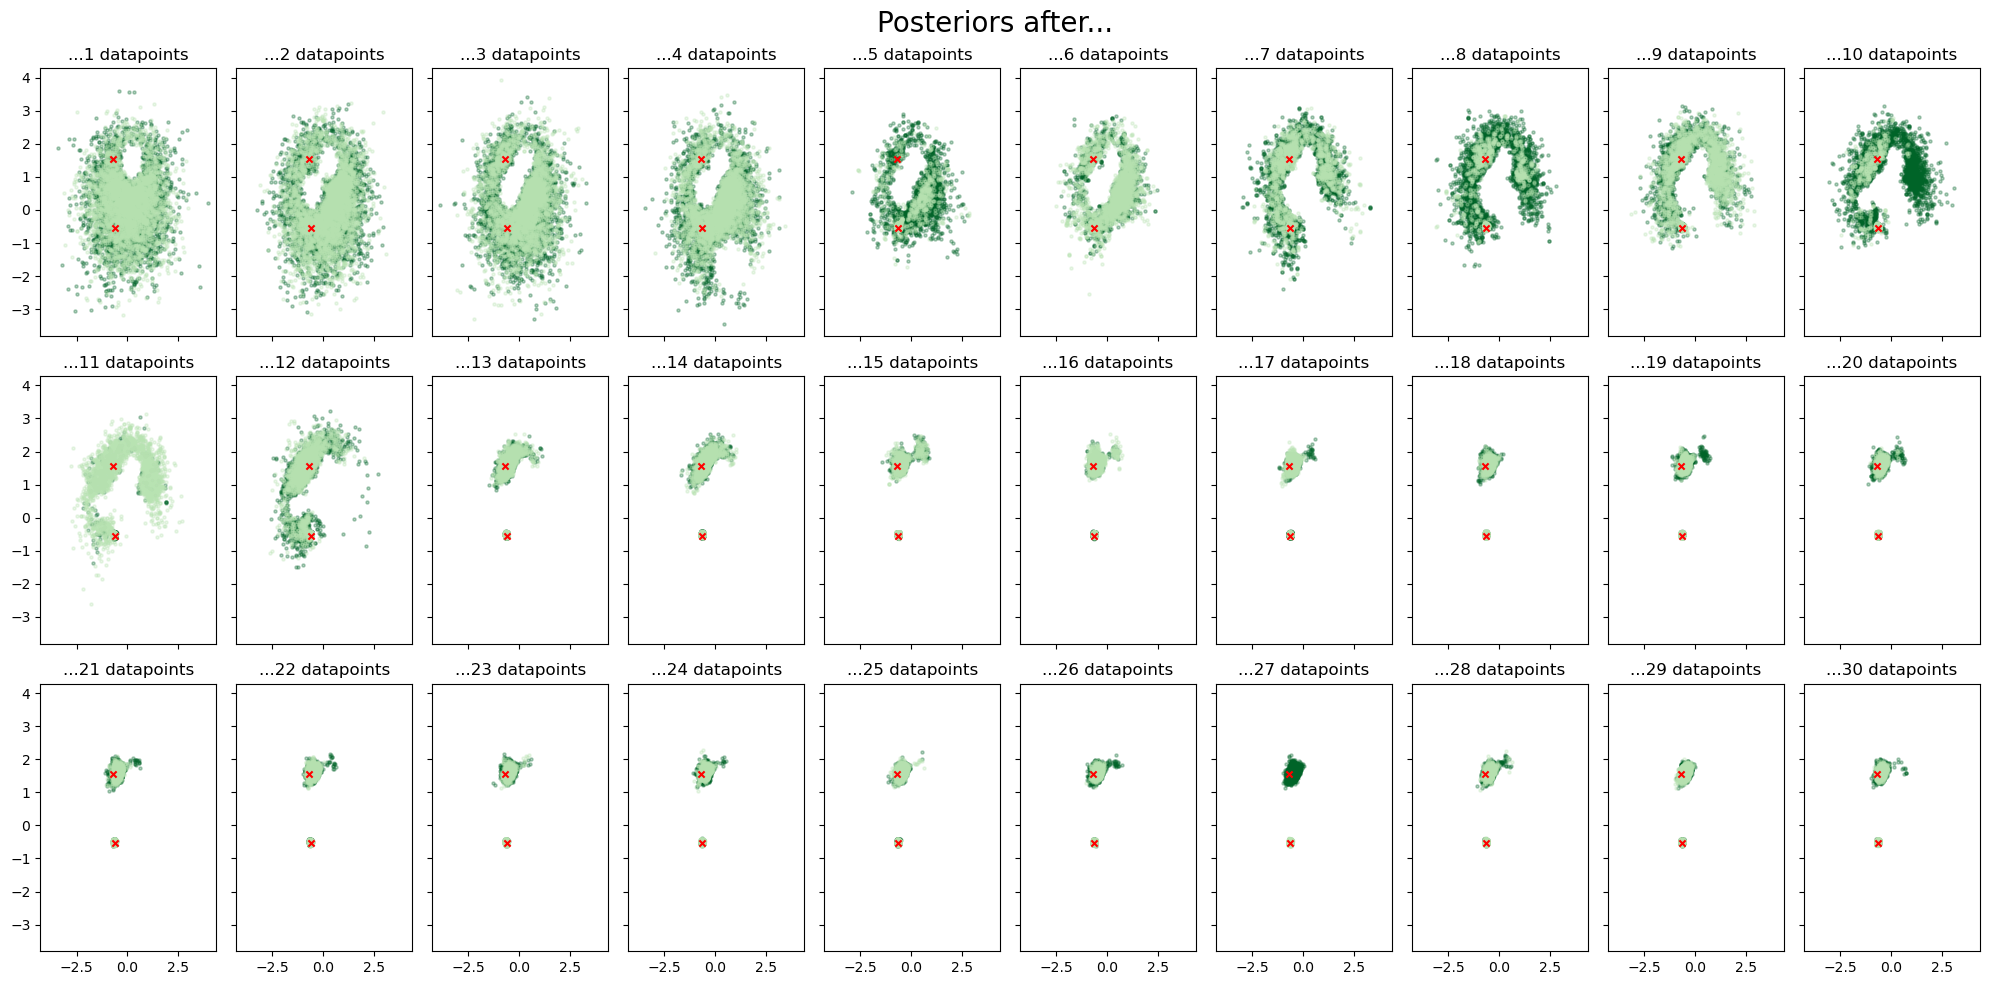

In [5]:
# plot as subplots, keep the same scale for each subplot
test_param_id_to_plot = 0
fig, axs = plt.subplots(num_designs//10, 10,  figsize=(20, 10), sharex=True, sharey=True)
# flatten the axs:
# use greens for the samples
cmap = plt.cm.Greens(np.linspace(0.3, 0.9, K)[::-1])

axs = axs.flatten()
for t in range(num_designs):
    samples = hmc_samples[t][test_param_id_to_plot] # [N, K, p]
    axs[t].set_title(f"...{t+1} datapoints")
    for k in range(K):
        axs[t].scatter(samples[:,k, 0], samples[:,k, 1], label=f"k={k}", s=5, alpha=0.3, color=cmap[k])
    # plot the true thetas too:
    for k in range(K):
        axs[t].scatter(
            test_thetas[test_param_id_to_plot, k, 0],
            test_thetas[test_param_id_to_plot, k, 1],
            c="red",
            s=20,
            marker="x",
        )

fig.suptitle("Posteriors after...", fontsize=20)
plt.tight_layout()
plt.show()

Two observations:
1. Clearly, a standard Gaussian variational family cannot capture these posteriors well.
2. The posteriors are symmetric (which can be seen from the model definition), i.e. we cannot distinguish between the two sources. We could change the model to make the parameters identifiable, or we could "symmetise" the posteriors to ensure we are closer to the ground truth.

Let's quickly do the second point first:

In [6]:
hmc_samples = []
for t in tqdm(range(num_designs), desc="Running HMC"):
    hmc_samples.append(
        _model.run_hmc_posterior(
            designs=illustrative_data["designs"][..., : (t + 1)],
            outcomes=illustrative_data["outcomes"][..., : (t + 1)],
            num_chains=4,
            num_samples=1000,
            symmetrise=True, # symmetrise the posteriors
        )  # [B, samples, K, p]
    )

Running HMC: 100%|██████████| 30/30 [02:25<00:00,  4.85s/it]


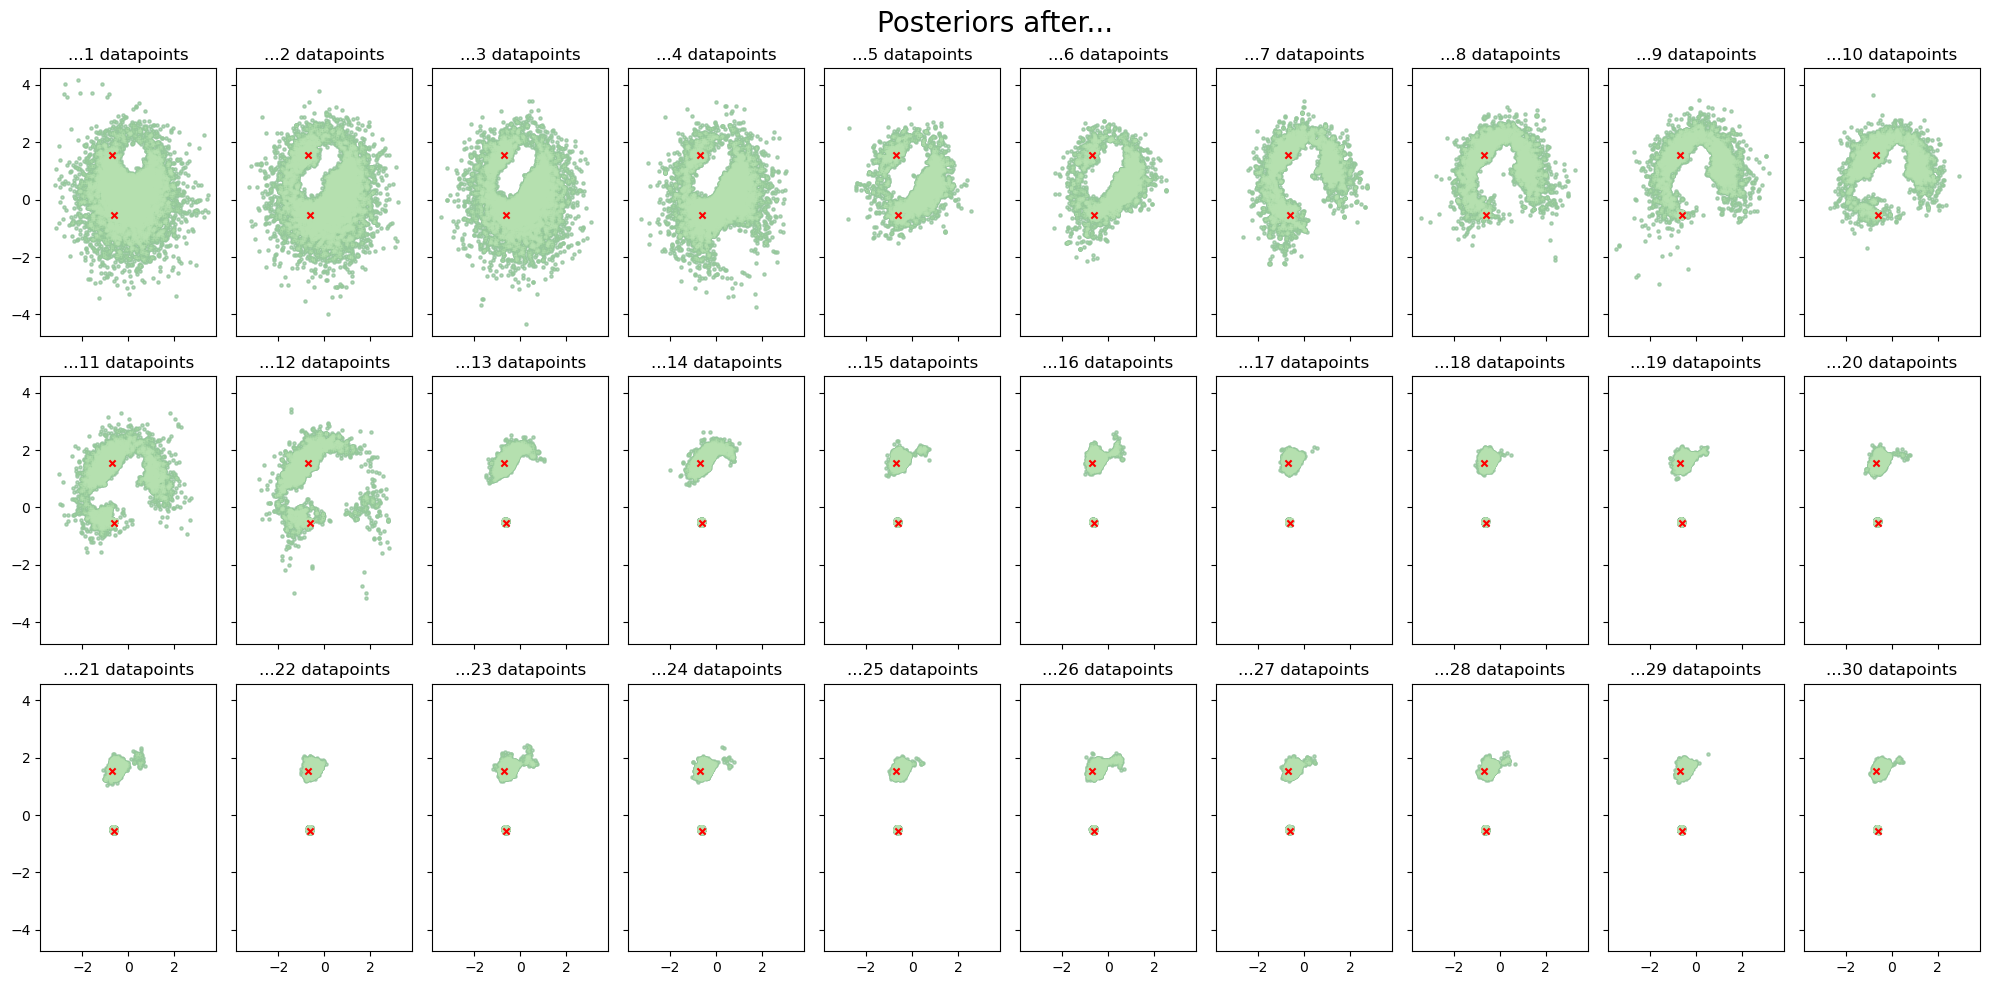

In [7]:
# plot as subplots, keep the same scale for each subplot
test_param_id_to_plot = 0
fig, axs = plt.subplots(
    num_designs // 10, 10, figsize=(20, 10), sharex=True, sharey=True
)
# flatten the axs:
# use greens for the samples
cmap = plt.cm.Greens(np.linspace(0.3, 0.9, K)[::-1])

axs = axs.flatten()
for t in range(num_designs):
    samples = hmc_samples[t][test_param_id_to_plot]  # [N, K, p]
    axs[t].set_title(f"...{t+1} datapoints")
    for k in range(K):
        axs[t].scatter(
            samples[:, k, 0],
            samples[:, k, 1],
            label=f"k={k}",
            s=5,
            alpha=0.3,
            color=cmap[k],
        )
    # plot the true thetas too:
    for k in range(K):
        axs[t].scatter(
            test_thetas[test_param_id_to_plot, k, 0],
            test_thetas[test_param_id_to_plot, k, 1],
            c="red",
            s=20,
            marker="x",
        )

fig.suptitle("Posteriors after...", fontsize=20)
plt.tight_layout()
plt.show()

We'll learn static designs using the BA bound (not in the DAD paper) as well as the PCE bound (which is what is used in the DAD paper). 
Starting with the BA bound, we'll use a normalising flow to parameterise the posterior. This is readily available in the `BayesFlow` library.


****Before training****


/Users/zizi/miniconda3/envs/bf-torch/lib/python3.11/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1720538194616/work/aten/src/ATen/native/TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


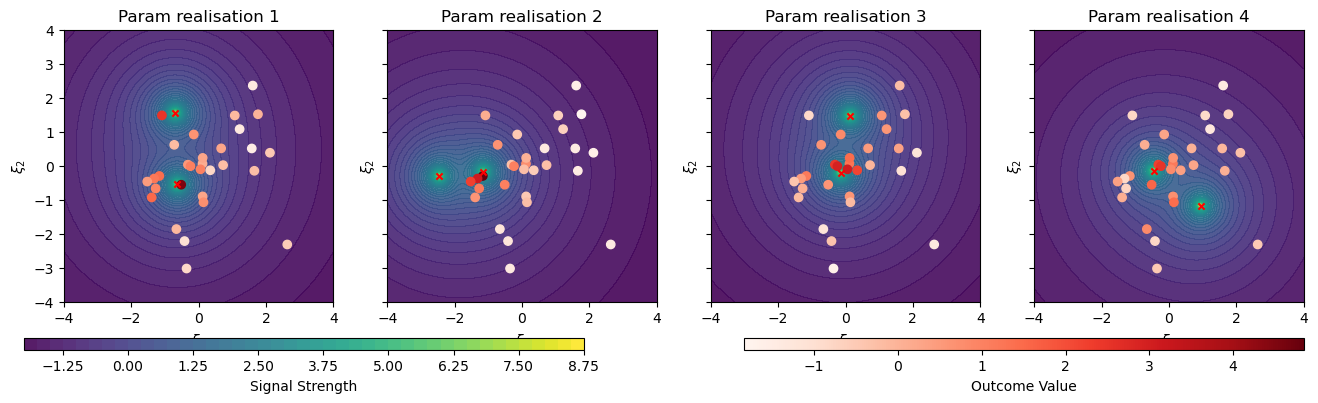

100%|██████████| 32/32 [00:23<00:00,  1.38it/s]


Lower bound: (8.03072452545166, 0.10849614545753236); Upper bound: (8.242598533630371, 0.1264548754611758)


Training: loss = -0.7539555430412292: 100%|██████████| 5000/5000 [03:00<00:00, 27.71it/s] 


In [8]:
print("****Before training****")
model_ba = LocationFinding(
    K=K,
    p=p,
    T=num_designs,
    design_func=StaticDesign(designs=torch.randn(num_designs, p), learn_designs=True),
)
model_ba.plot_realisations(params=test_thetas, **model_ba.run_policy(test_thetas))
eig_estimates = nmc_eval.estimate(params=eval_thetas, **model_ba.run_policy(eval_thetas))
print(f"Lower bound: {eig_estimates['lb']}; Upper bound: {eig_estimates['ub']}")

# let's fit a posterior:
with torch.enable_grad():
    posterior_net = bf.networks.CouplingFlow()
    posterior_net.build(
        xz_shape=(64, num_params), conditions_shape=(64, num_designs * (p + 1))
    )
    # train the designs:
    optim = torch.optim.AdamW(
        list(posterior_net.parameters()) + list(model_ba.design_func.parameters()), lr=5e-3
    )
    # cosine annealing
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optim, T_max=num_grad_steps, eta_min=1e-5
    )
    pbar = trange(num_grad_steps, desc="Training: loss =")

    for i in pbar:
        optim.zero_grad()
        # theta is [B, K, p]; designs are [B, p, T]; outcomes are [B, 1, T]
        theta, designs, outcomes = model_ba(batch_shape=train_batch_shape).values()
        # flatten the designs and outcomes --> [B, (p+1)*T]; we could choose to only condition on the outcomes.
        design_obs_pairs_flattened = torch.cat([designs.detach(), outcomes], dim=-2).flatten(-2)
        logprobs = posterior_net.log_prob(
            theta.flatten(-2), conditions=design_obs_pairs_flattened
        )
        loss = -logprobs.mean(-1)
        loss.backward()
        optim.step()
        scheduler.step()
        if i % 50 == 0:
            pbar.set_description(f"Training: loss = {loss}")

****After training****


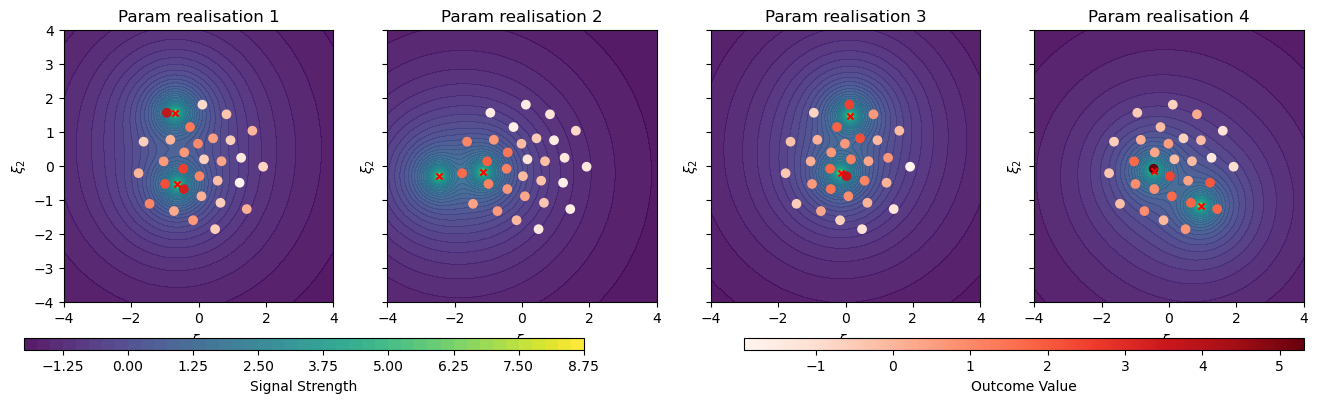

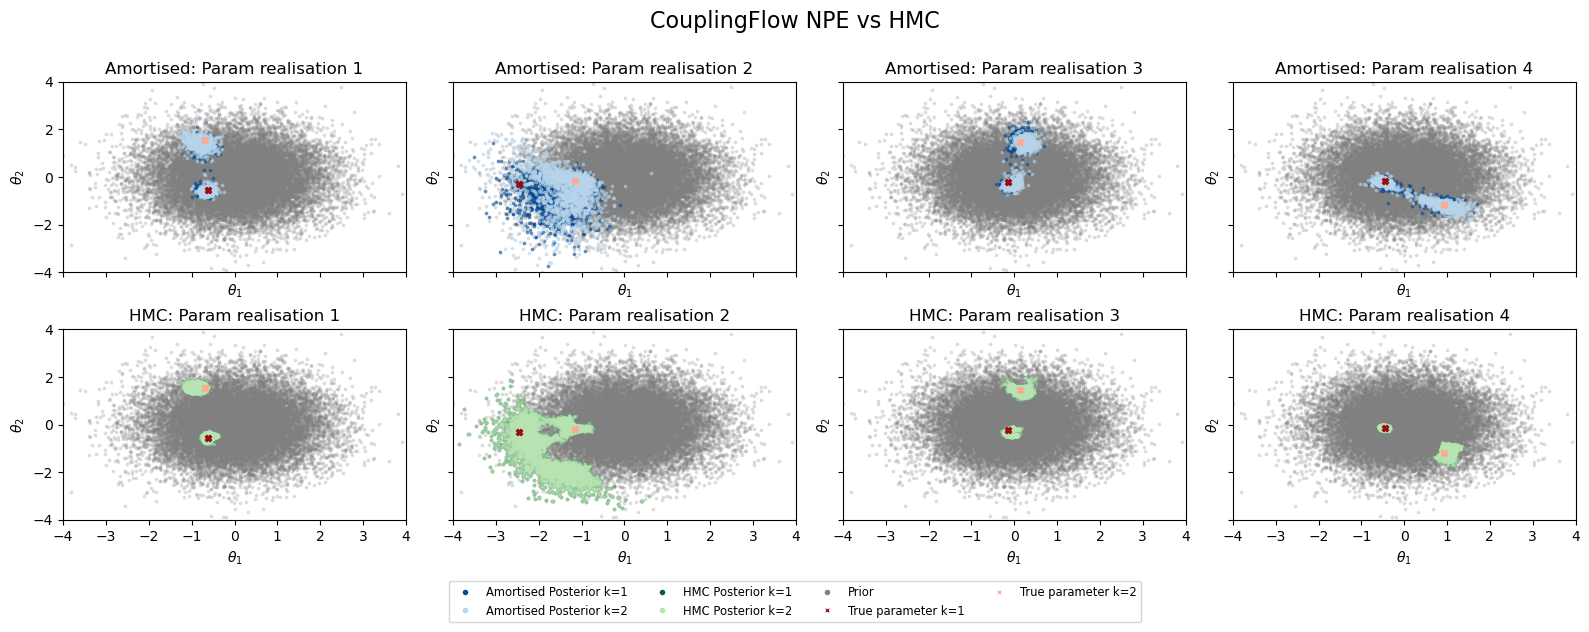

100%|██████████| 32/32 [00:23<00:00,  1.35it/s]

Lower bound: (8.709768295288086, 0.0989111723894576); Upper bound: (9.009517669677734, 0.11711196228081124)


In [9]:
# sample from the amortised posterior
# need to sample new designs and outcomes, use the same theta
print("****After training****")
post_train_test_dataset = model_ba.run_policy(test_thetas)
model_ba.plot_realisations(params=test_thetas, **post_train_test_dataset)
amortised_posterior_samples = torch.stack(
    [
        posterior_net.sample(
            (2000,),
            conditions=torch.cat([dd, yy], dim=-2).flatten(-2).expand(2000, -1),
        )
        for dd, yy in zip(
            post_train_test_dataset["designs"], post_train_test_dataset["outcomes"]
        )
    ],
    dim=0,
)  # [B, N_post_samples, p*K]
amortised_posterior_samples = amortised_posterior_samples.view(
    *amortised_posterior_samples.shape[:-1], K, p
)

# sample from the hmc posterior: [B, N_post_samples, K, p]
hmc_posterior_samples = model_ba.run_hmc_posterior(
    **post_train_test_dataset, symmetrise=True
)
plot_posterior_comparison(
    true_theta=test_thetas,  # [B, K, p]
    amortised_samples=amortised_posterior_samples,  # [B, N_post, K, p]
    hmc_samples=hmc_posterior_samples,  # [B, N_post, K, p]
    prior_samples=model_ba.prior().sample((10000,)),  # [N, K, p]
)
# evaluate the design strategy after training:
eig_estimates = nmc_eval.estimate(params=eval_thetas, **model_ba.run_policy(eval_thetas))
print(f"Lower bound: {eig_estimates['lb']}; Upper bound: {eig_estimates['ub']}")

The EIG estimates we obtain here (recall, these are only for 32 rollouts) are pretty close to those reported in Table 1 of the paper (lower bound $8.838 \pm 0.039$, upper bound $8.914 \pm 0.038$) and well within the error bounds. The cool thing about using this bound is that we also get approximate posteriors!

The NF posteriors are not perfect but certainly do a better job than a standard Gaussian. They are able to capture multiple modes and have learnt the symmetry in the model. More training and bigger model will likely help a lot. 


Let's also train the static design with the PCE bound.

****Before training****


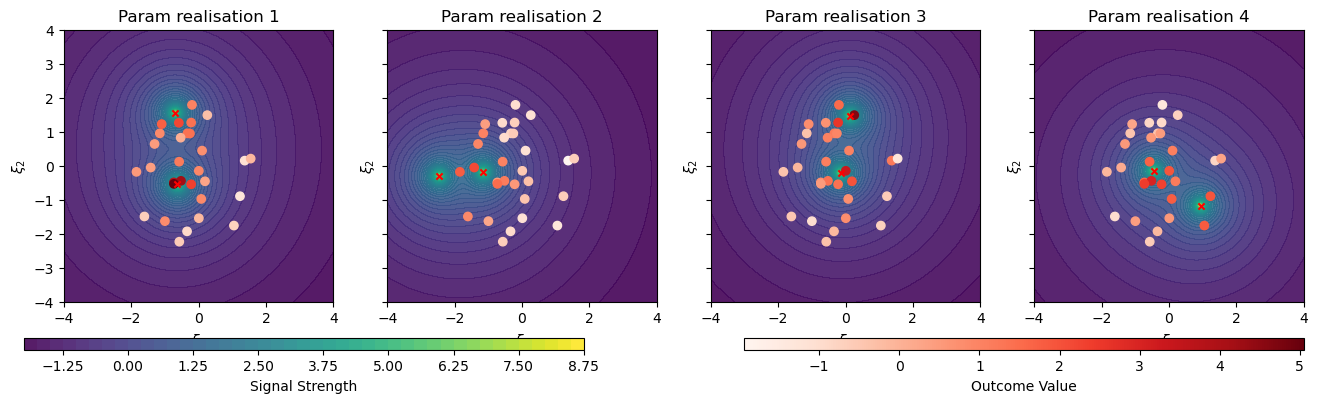

100%|██████████| 32/32 [00:23<00:00,  1.36it/s]


Lower bound: (8.06195068359375, 0.14395834574391667); Upper bound: (8.206689834594727, 0.15838901574227382)


Training: loss = 0.017862074077129364: 100%|██████████| 5000/5000 [01:46<00:00, 47.03it/s] 


In [10]:
# initialise the model again
model_pce = LocationFinding(
    K=K,
    p=p,
    T=num_designs,
    design_func=StaticDesign(designs=torch.randn(num_designs, p), learn_designs=True),
)
objective = NestedMonteCarlo(
    prior=model_pce.prior(),
    outcome_likelihood=model_pce.outcome_likelihood,
    num_inner_samples=128,
)
print("****Before training****")
model_pce.plot_realisations(params=test_thetas, **model_pce.run_policy(test_thetas))
eig_estimates = nmc_eval.estimate(params=eval_thetas, **model_pce.run_policy(eval_thetas))
print(f"Lower bound: {eig_estimates['lb']}; Upper bound: {eig_estimates['ub']}")

with torch.enable_grad():
    # train the designs:
    optim = torch.optim.AdamW(model_pce.design_func.parameters(), lr=5e-3)
    # cosine annealing
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optim, T_max=num_grad_steps, eta_min=1e-5
    )
    pbar = trange(num_grad_steps, desc="Training: loss =")

    for i in pbar:
        optim.zero_grad()
        # theta is [B, K, p]; designs are [B, p, T]; outcomes are [B, 1, T]
        training_batch = model_pce(batch_shape=train_batch_shape)
        loss, _ = objective.differentiable_loss(**training_batch)
        loss.backward()
        optim.step()
        scheduler.step()
        if i % 50 == 0:
            pbar.set_description(f"Training: loss = {loss}")

****After training****


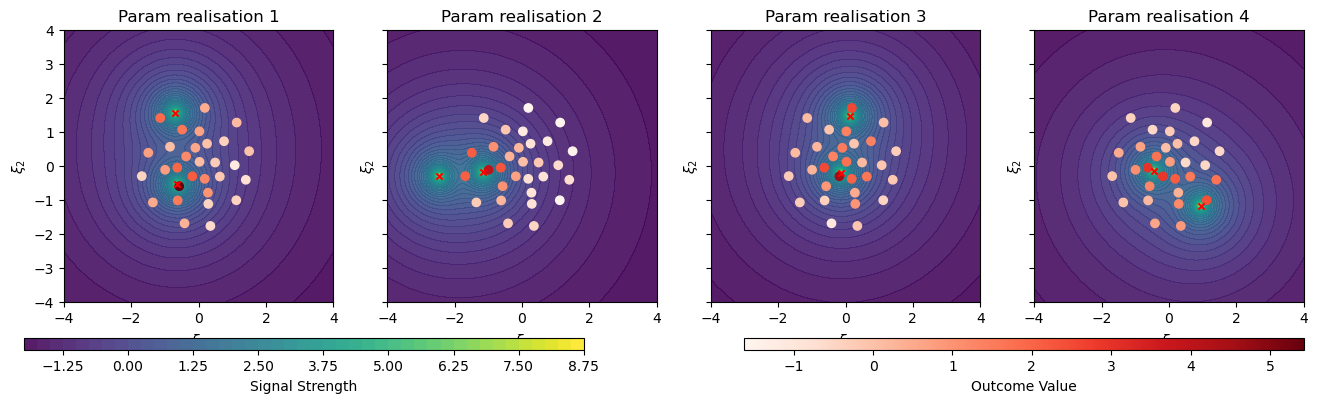

100%|██████████| 32/32 [00:23<00:00,  1.39it/s]

Lower bound: (8.677703857421875, 0.1263639647089378); Upper bound: (8.876051902770996, 0.14056101472599905)


In [11]:
print("****After training****")
model_pce.plot_realisations(params=test_thetas, **model_pce.run_policy(test_thetas))
# evaluate the design strategy after training:
eig_estimates = nmc_eval.estimate(params=eval_thetas, **model_pce.run_policy(eval_thetas))
print(f"Lower bound: {eig_estimates['lb']}; Upper bound: {eig_estimates['ub']}")

The desgins look roughly the same as the ones learnt with the BA bound.
Similarly, the EIG esitmates are similar to those above and those reported in the paper.

In [12]:
model_pce.design_func.designs.shape

torch.Size([30, 2])

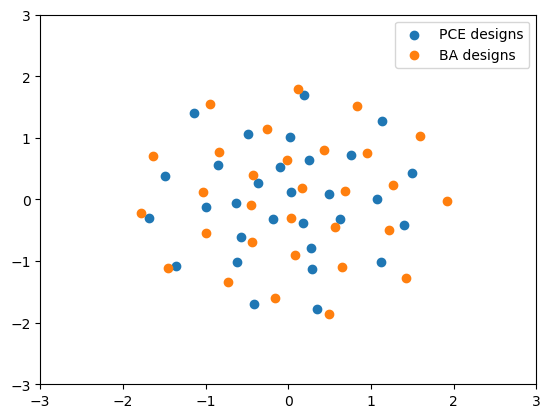

In [13]:
plt.figure()
plt.scatter(*model_pce.design_func.designs.T, label="PCE designs")
plt.scatter(*model_ba.design_func.designs.T, label="BA designs")
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.legend()
plt.show()


### Myopic design

In [14]:
model_myopic = LocationFinding(
    K=K,
    p=p,
    T=1,
    design_func=lambda x: x, # placeholder, it gets initialised in the function
)

eval_thetas_flattened = eval_thetas.flatten(0, 1)  # [[b1, b1], K, p] -> [b1*b2, K, p]

In [15]:
# Parallelise the run_myopic_design function
parallel_results_hmc = Parallel(n_jobs=-1)(
    delayed(run_myopic_design)(
        model_myopic, theta.unsqueeze(0), num_designs, num_grad_steps, plot=False
    )
    for theta in eval_thetas_flattened
)
parallel_results_hmc = {
    key: torch.cat([result[key] for result in parallel_results_hmc], dim=0)
    for key in parallel_results_hmc[0].keys()
}

# Reshape results to match evaluation batch shape
parallel_results_hmc = {
    key: value.view(*eval_batch_shape, *value.shape[1:])
    for key, value in parallel_results_hmc.items()
}

/Users/zizi/miniconda3/envs/bf-torch/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Design

In [17]:
# Estimate expected information gain
eig_estimates = nmc_eval.estimate(**parallel_results_hmc)
# Print bounds of expected information gain
print(f"EIG Bounds - Lower: {eig_estimates['lb']}, Upper: {eig_estimates['ub']}")

100%|██████████| 32/32 [00:22<00:00,  1.41it/s]

EIG Bounds - Lower: (10.905694961547852, 0.06941844099191376), Upper: (41.07815170288086, 3.18210628153542)


[1] Foster, A., Ivanova, D. R., Malik, I., & Rainforth, T. (2021, July). Deep adaptive design: Amortizing sequential bayesian experimental design. In International conference on machine learning (pp. 3384-3395). PMLR.